# Index Optimizer

## Data

### Index selection for trading universe

For this exercise, the S&P 500 has been chosen as the benchmark index. To initiate the process of building our trading universe, we began with a list of component stocks obtained from [SlickCharts](https://www.slickcharts.com/sp500).

The tickers and related information have been saved in a CSV file located at:

```bash
./data/tickers.csv
```

### Stock price data

#### Stock Price Data Collection

We collected stock price data using the `yfinance` package, retrieving information from Yahoo Finance. The following details pertain to the data collection:

- **Source**: Yahoo Finance
- **Time Horizon**: From January 1, 2020, to August 9, 2023
- **Frequency**: Daily
- **Fields**: Specifically, the [Adj Close] prices were retrieved.

This comprehensive dataset provides the adjusted closing prices of various stocks, offering a valuable resource for analyzing and modeling stock performance over the specified time period.


In [120]:
import yfinance as yf
import pandas as pd

ticker_path = './data/tickers.csv'
tickers = pd.read_csv(ticker_path, header=None).values.ravel().tolist()

start_date = '2020-01-01'
end_date = '2023-08-09'
raw = yf.download(tickers, period='1d', start=start_date, end=end_date)['Adj Close']

In [121]:
raw.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,83.948051,28.982893,147.959595,73.249023,75.656319,80.618294,81.730186,43.400002,199.225403,334.429993,...,142.082199,56.588821,58.530796,54.796291,76.566856,95.838898,141.097351,259.140015,46.758446,130.800995
2020-01-03,82.600197,27.548195,147.968918,72.536880,74.938194,79.604416,80.733833,43.349998,198.893631,331.809998,...,139.974716,56.860973,58.060234,54.189899,77.017525,95.538712,140.728531,256.049988,46.098621,130.820480
2020-01-06,82.844353,27.219410,145.537079,73.114876,75.529579,80.769913,81.156792,43.520000,197.594818,333.709991,...,139.697678,56.779320,58.506031,54.488281,76.518913,95.482437,139.915176,258.010010,45.536877,129.816162
2020-01-07,83.098312,27.119778,143.810699,72.771019,75.098701,80.191895,80.705635,43.160000,193.328766,333.390015,...,140.360596,56.661400,58.027218,54.777046,76.231239,95.651268,139.792297,256.470001,45.260456,130.254959
2020-01-08,83.918770,27.737495,142.158554,73.941635,75.630974,80.968880,81.034599,42.730000,193.707947,337.869995,...,141.241196,56.606960,57.152130,55.354546,76.490128,95.820137,141.466156,247.639999,45.706291,129.972168


#### Handling Invalid Price Data

It's important to note that not all tickers have valid price data throughout the specified time period. Various reasons can lead to missing or incomplete data. One illustrative example is the case of Laboratory Corporation of America Holdings (NYSE: LH).

During the provided time frame, a significant event occurred for LH. A spin-off of Fortrea Holdings Inc. (FTRE) was announced, with FTRE being listed on the Nasdaq Global Select Market. The record date for this spin-off was June 20, 2023. On this date, LH shareholders became eligible to receive one (1) share of FTRE for each share of LH held. The distribution of FTRE shares to LH shareholders took place on June 30, 2023. Consequently, the first day of "regular way" trading for FTRE shares was expected to be July 3, 2023.

Due to such events and other factors, some tickers may lack valid price data for the complete historical period. To facilitate the demonstration of the index optimizer, tickers without valid price data for the entire history were removed. This approach ensures that the optimizer operates on a consistent dataset, enabling effective showcase of its functionalities.


In [20]:
to_exclude = set(col for col in tickers if raw[col].isnull().sum() != 0)
df_px =  raw[[ticker for ticker in tickers if ticker not in to_exclude]] 
df_px.to_csv('./data/px.csv')

Zip the file to save space.

In [16]:
!zip ./data/px.csv.zip ./data/px.csv

  adding: data/px.csv.new (deflated 65%)


## Build the optimizer

### Problem setup
#### General formulation
Portfolio optimization under Markowitz framework is a quadratic programming problem.

Consider the following quadratic programming problem:

Minimize:
\begin{align*}
    & \frac{1}{2} \mathbf{x}^T \mathbf{Q} \mathbf{x} + \mathbf{c}^T \mathbf{x}
\end{align*}

Subject to:
\begin{align*}
    & \mathbf{A}_{eq} \mathbf{x} = \mathbf{b}_{eq} \quad \text{(Equality Constraints)} \\
    & \mathbf{Q}_{ineq} \mathbf{x} \leq \mathbf{h}_{ineq} \quad \text{(Inequality Constraints)}
\end{align*}

Where:
\begin{align*}
    & \mathbf{x} = [x_1, x_2, \ldots, x_n]^T \quad \text{(Vector of new positions to find)} \\
    & \mathbf{Q} \quad \text{(Positive semi-definite quadratic coefficient matrix)} \\
    & \mathbf{c} = [c_1, c_2, \ldots, c_n]^T \quad \text{(Signal vector for each stock)} \\
    & \mathbf{A}_{eq} \quad \text{(Matrix of equality constraint coefficients)} \\
    & \mathbf{b}_{eq} = [b_{eq_1}, b_{eq_2}, \ldots, b_{eq_m}]^T \quad \text{(Vector of equality constraint constants)} \\
    & \mathbf{Q}_{ineq} \quad \text{(Matrix of inequality constraint coefficients)} \\
    & \mathbf{h}_{ineq} = [b_{ineq_1}, b_{ineq_2}, \ldots, b_{ineq_p}]^T \quad \text{(Vector of inequality constraint constants)}
\end{align*}

#### Portfolio Assumptions and Requirements

Throughout this exercise, we make certain key assumptions about the portfolio, along with established requirements for the optimization process:

**Assumptions:**

1. **Full Capital Investment**: The entire capital is deployed in the portfolio.
2. **Long-Only Strategy**: Only long positions are permitted; short positions are excluded.
3. **End-of-Day Rebalancing**: Portfolio rebalancing occurs at the end of each trading day.
4. **No Additional Capital Flow**: The portfolio does not experience additional capital inflow.

**Requirements:**

1. **Weight Deviation Limit**: The weight of each portfolio component is restricted to deviate from the index weight by no more than 3%.
2. **Turnover Constraint**: The weight turnover in the portfolio is limited to 15% or less.

Considering these assumptions and requirements, we expand the scope of this problem. While initially dealing with n variables, we extend it to incorporate 3n variables to account for stocks traded during rebalancing. Specifically, this expansion introduces two additional variables, $x_{buy}$ and $x_{sell}$, for each stock. These variables play a crucial role in the optimization process, allowing for the management of buy and sell orders during rebalancing.


**Problem setup**:

Minimize:
\begin{align*}
    & \frac{1}{2} \mathbf{x}^T \mathbf{Q} \mathbf{x} + \mathbf{c}^T \mathbf{x}
\end{align*}

Subject to:
\begin{align*}
    & \sum_{i=1}^{N} x_i = 1 \\
    & x_i = x_{0,i} + x_i^+ - x_i^-, i \in [1, N] \\
    & \sum_{i=1}^N x_i^+ + \sum_{i=1}^N x_i^- \le \tau \\
    & \mathbf{lb} <= x_i <= \mathbf{ub}, i \in [1, N] \\
    & 0 <= x_i^+ <=1, i \in [1, N] \\
    & 0 <= x_i^- <=1, i \in [1, N] \\
\end{align*}

Where:
\begin{align*}
    & \mathbf{lb} \quad \text{ is the lower bound of } x \text{, allowing up to a 3\% deviation from the index} \\
    & \mathbf{ub} \quad \text{ is the upper bound of } x \text{, allowing up to a 3\% deviation from the index} \\
    & \mathbf{Q} \quad \text{Positive semi-definite quadratic coefficient matrix} \\
    & \mathbf{c} = [c_1, c_2, \ldots, c_n]^T \quad \text{Signal vector for each stock} \\
    & \mathbf{x}_i^+ \quad \text{notional of buy orders on rebalance} \\
    & \mathbf{x}_i^- \quad \text{notional of sell orders on rebalance} \\
    & \mathbf{\tau} \quad \text{maximum turnover} \\
\end{align*}

#### Portfolio Constraints

To effectively manage the optimization process, a set of five distinct constraints has been defined and integrated into the solution:

1. **ConstraintInterface**: This serves as interface base class.
2. **FullyInvestConstraint**: Ensures that the entire capital is invested within the portfolio.
3. **AccountingConstraint**: Manages the accounting of stock positions and trade notional values.
4. **TurnoverConstraint**: Monitors and controls portfolio turnover, upholding the defined turnover limit.
5. **IndexDeviateConstraint**: Keeps track of deviations from index weights, ensuring they remain within the specified 3% threshold.
6. **TradeNotionalConstraint**: Governs the trade notional values.

For the technical intricacies of each constraint's implementation, the code itself serves as the definitive reference. Through the careful integration of these constraints, the optimization process aligns with the defined assumptions and requirements, culminating in a robust and effective portfolio management strategy.


## Backtesting

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from opt.constraints import AccountingConstraint
from opt.constraints import FullyInvestConstraint
from opt.constraints import TradeNotionalConstraint
from opt.constraints import TurnoverConstraint
from opt.constraints import IndexDeviateConstraint
from opt.optimizer import Optimizer

In [119]:
# loading in data
df = pd.read_csv('./data/px.csv.zip', compression='zip', parse_dates=['Date']).set_index('Date')

In [3]:
# calculate covariance
# dfr is the daily simple returns
dfr = (df.diff().shift(-1) / df).dropna()
dfr.index = df.index[1:]

# use data from 2020-01-02 to 2021-12-31 as training data to calibrate the covariance
cov = dfr.query('Date < 20230101').cov().values

In [4]:
# check cov
assert np.isnan(cov).sum() == 0

We are going to run the backtest on dataset from 20230101 to 20230809

In [ ]:
tickers = df.columns.tolist()
df_px = df.query('Date >= 20221230')
px = df_px.values

px.shape

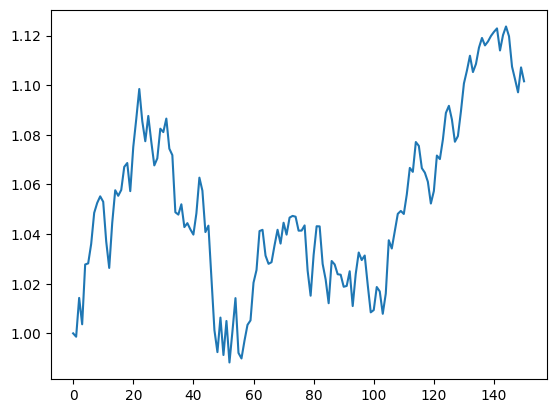

In [123]:
n = len(df_px.columns)
idx = (np.ones(n) / n / px[0]) * px
ret = dfr.values[-N:, :]

plt.plot(np.sum(idx, axis=1));

#### Rebalancing Assumptions

A set of additional specific assumptions has been established regarding the rebalancing process:

1. **Index Rebalance Exemption**: During the period from January 3, 2023, to August 8, 2023, the index itself does not undergo any rebalancing. This time frame is characterized by stability in the index composition.
2. **Transaction Cost Absence**: All transactions carried out during rebalancing are conducted without incurring any transaction costs. This assumption eliminates the influence of fees on the optimization strategy.
3. **Odd Lot Trading**: The ability to trade fractional shares is considered, permitting the execution of trades involving fractions of individual stocks. This flexibility accommodates precise portfolio adjustments.

These assumptions provide the groundwork for the optimization process, shaping the strategy according to the specified parameters and guiding the development of an effective portfolio management solution.


The following data is derived from the market:

- $ret$: Daily return for each asset, with a shape of (150, 498).
- $idx$: Composition of the index, which initially holds equal weights and evolves over time, with a shape of (151, 498).

For each trading day, the following information is available:

- $sod_i$: Positions at the start of the day after optimization.
- $eod_i$: Positions at the end of the day, calculated as $sod_i * (1 + ret)$.

The portfolio rebalancing process involves two steps:

1. Adjusting the weights of the portfolio (end-of-day positions) to align with the index weights.
2. Running an optimization process to construct the optimal portfolio.

During the first step, we aim to adhere to a predetermined turnover limit, with any remaining quota passed on to the optimizer.

$eod\_rebal_i$: Represents positions after the adjustment to match the index, with a shape of (151, 498). Initially, $eod\_rebal_0$ equals $idx_0$.

For the purpose of demonstration, we intentionally forecast ahead and generate our signal as $ret_{i+1} + z_i$, where $z_i$ is a standard normal random variable with a standard deviation of 0.01.


In [107]:
# use sod, eod to hold
np.random.seed(0)

N = px.shape[0] - 1  # number of trading dates
n = px.shape[1]  # number of tickers

eod_rebal = np.zeros((N+1, n))  # the matrix to hold positions after we same shape as idx
sod = np.zeros((N, n))
eod = np.zeros((N, n))

buys, sells = np.zeros(N), np.zeros(N)

In [109]:
optimizer = Optimizer(tickers, cov)

In [ ]:
signal_std = 0.01
turnover_limit = 0.15
idx_dev = 0.03

turnover = np.zeros(N)

# for the first trading day
eod_rebal[0, :] = np.copy(idx[0, :])
quota_used = 0
total_capital = 1

for i, date in enumerate(dfr.index[-N:]):
    
    if i > 0:
        total_capital = np.sum(eod[i-1, :])
        eod_rebal[i, :] = idx[i, :] / np.sum(idx[i, :]) * total_capital 
        quota_used = np.abs(eod[i-1, :] - eod_rebal[i, :]).sum() / total_capital
        turnover[i] += quota_used
    
    quota_left = max(0, turnover_limit - quota_used)
    signal = np.random.randn(n) * signal_std + ret[i, :]  # assume we have crystal ball
    x0 = eod_rebal[i, :] / total_capital  # current position before optimization
    
    constraints = [
        FullyInvestConstraint(tickers),
        AccountingConstraint(tickers, x0),
        TradeNotionalConstraint(tickers),
        TurnoverConstraint(tickers, quota_left),
        IndexDeviateConstraint(tickers, idx[0, :], idx_dev),
    ]

    print(f'working on solving optimization problem for date: {date}')
    res = (
        optimizer
        .reset()
        .update_x0(x0)
        .update_signal(signal)
        .add_constraints(constraints)
        .solve()
    )
    
    sod[i, :] = res[:n] * total_capital
    buys[i] = res[n:2*n].sum()
    sells[i] = res[2*n:].sum()
    eod[i, :] = sod[i, :] * (1 + ret[i, :])

In [113]:
df_res = pd.DataFrame(
    {
        'idx': np.sum(idx, axis=1),
        'eod_rebal': np.sum(eod_rebal, axis=1),
        'sod': np.append([1], np.sum(sod, axis=1)),
        'eod': np.append([1], np.sum(eod, axis=1)),
        'turnover': np.append([0], turnover),
        'buys': np.append([0], buys),
        'sells': np.append([0], sells),
    },
    index = dfr.index[-N-1:],
)

With our crystal ball signal, the optimal portfolio 

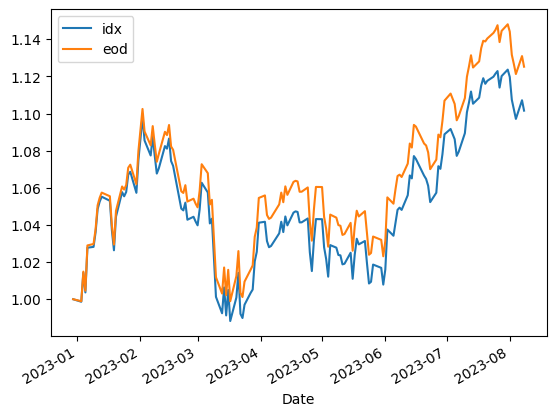

In [114]:
df_res[['idx', 'eod']].plot();

Cumulated excess return given the initial capital 10M:

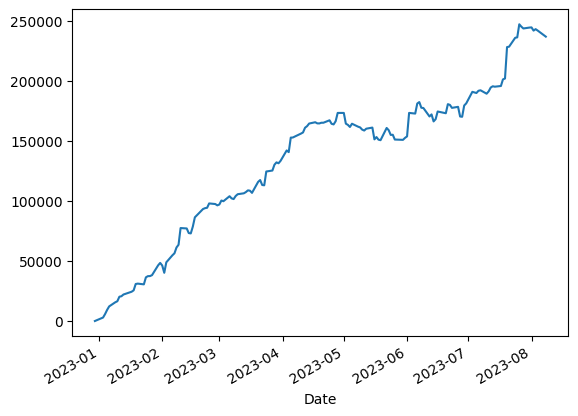

In [94]:
df_res.eval('excess=(eod-idx)*1e7')['excess'].plot();

Let's plot the daily turnover. As we can see, all within the 0.15 limits.

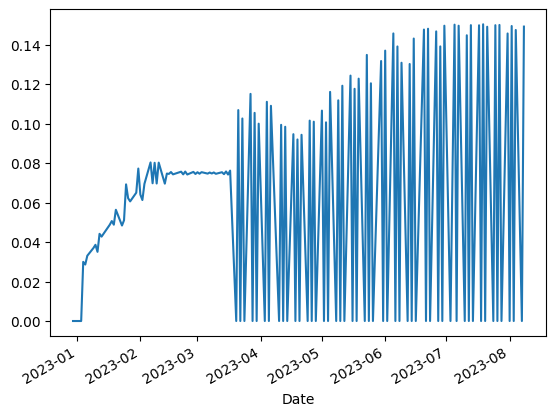

In [117]:
df_res['turnover'].plot();

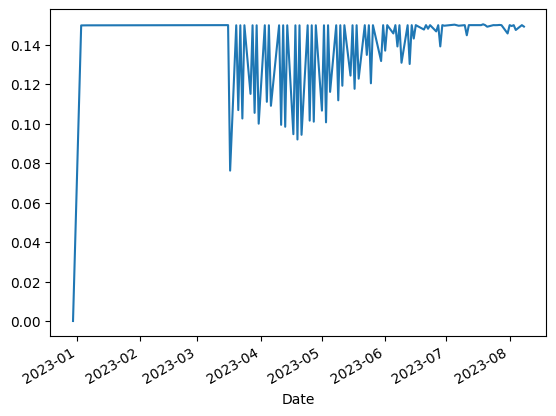

In [118]:
df_res.eval('turnover=turnover+buys+sells')['turnover'].plot();